In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'cyclegan' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

In [3]:
from library.mnist import prepare_mnist_dataset
tf_train, tf_test = prepare_mnist_dataset('mnist')

In [4]:
def create_contrast_dataset(tf_data):
    """
    Pomocna funkcija koja formira skup podataka parova slika sa razlicitim kontrakstima:
    - Prva slika ima crnu pozadinu i beli broj.
    - Druga slika ima belu pozadinu i crni broj.
    :param tf_data: Skup podataka iz sveske 1
    :return: Formiran skup podataka
    """
    tf_data = tf_data.map(lambda _, x: (x, 1-x))
    tf_data_x = tf_data.map(lambda x, y: x)
    tf_data_y = tf_data.map(lambda x, y: y)
    tf_data_y = tf_data_y.shuffle(400)
    return tf.data.Dataset.zip((tf_data_x, tf_data_y))

tf_train_contrast = create_contrast_dataset(tf_train)
tf_test_contrast = create_contrast_dataset(tf_test)

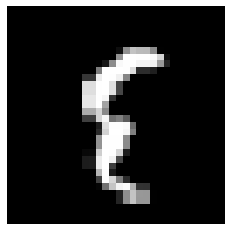

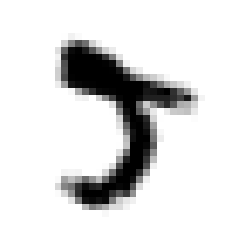

In [5]:
from library.visualization import show_image
for x, y in tf_train_contrast.take(1):
    show_image(x[5])
    show_image(y[5])

In [6]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
    generator_builder.add_downsample_layer(32, 3)
    generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
    return generator_builder.build()

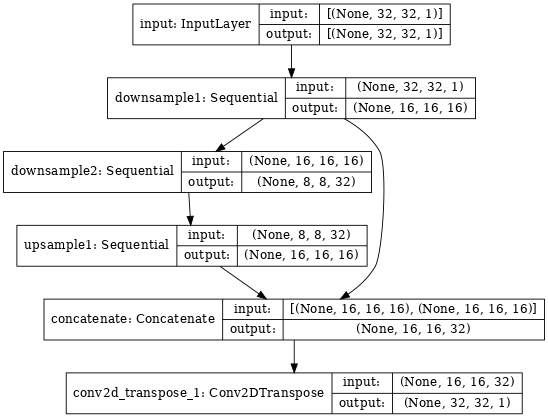

In [7]:
generator_g = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
generator_f = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

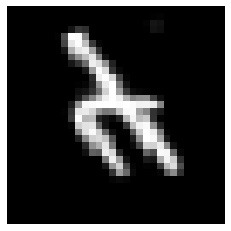

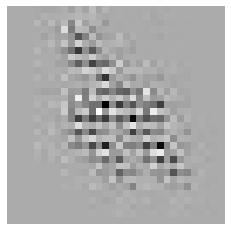

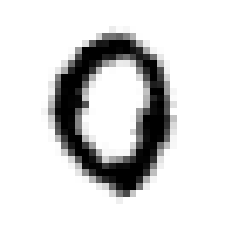

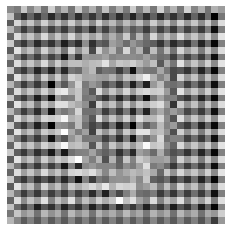

In [8]:
for x, y in tf_train_contrast.take(1):
    show_image(x[3])
    show_image(generator_g(x)[3])
    show_image(y[3])
    show_image(generator_f(y)[3])

In [9]:
from library.unet_generator import downsample

def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
    x = inputs
    x = downsample(16, 4, apply_batchnorm=False)(x)
    x = downsample(32, 4)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)
    return keras.Model(inputs=inputs, outputs=x)

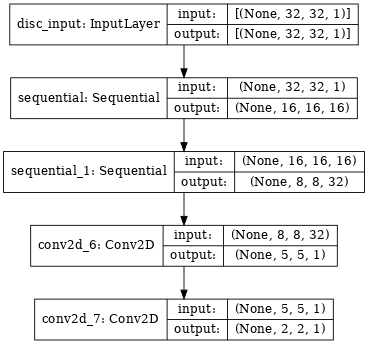

In [10]:
discriminator_x = create_discriminator(input_size=IMG_SIZE)
discriminator_y = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

In [11]:
# Podesavanje optimizatora
generator_f_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)
generator_g_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)

In [12]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

default_disc_alpha = 5
default_gen_alpha = 6
default_cycle_alpha = 3
default_identity_beta = 5


def discriminator_loss(real_images, generated_images, alpha):
    real_loss = bce(tf.ones_like(real_images), real_images)
    gen_loss = bce(tf.zeros_like(generated_images), generated_images)
    return (real_loss + gen_loss) * alpha


def generator_loss(generated_images, alpha):
    return bce(tf.ones_like(generated_images), generated_images) * alpha


def cycle_loss(real_images, cycled_images, alpha):
    return tf.reduce_mean(tf.abs(real_images - cycled_images)) * alpha


def identity_loss(real_images, generated_image_of_same_type, alpha, beta):
    return tf.reduce_mean(tf.abs(real_images - generated_image_of_same_type)) * alpha * beta

In [13]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [14]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

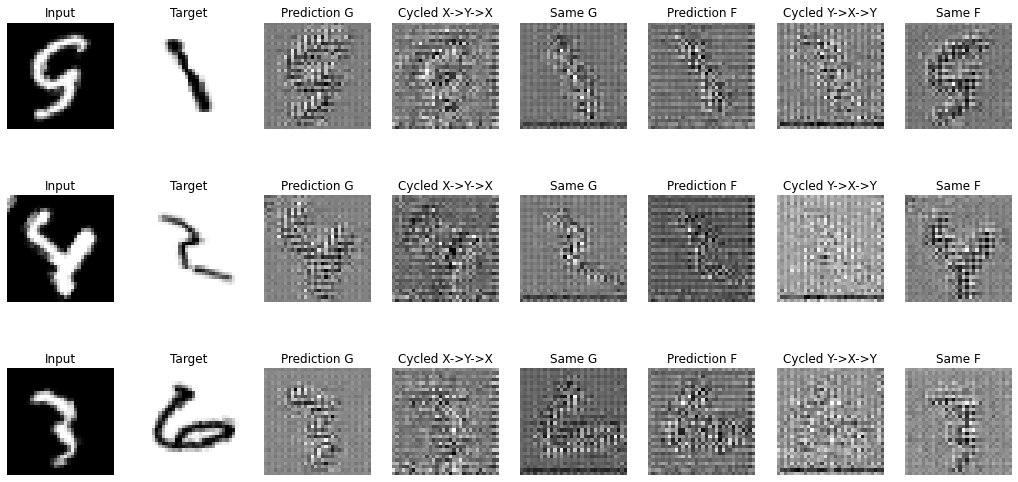

In [15]:
def test_image_generation(gen_g, gen_f, input_batch, target_batch, img_size, rows=3):
    """
    Pomocna funkcija za vizualizaciju perfomansi modela.
    :param gen_g: G Generator
    :param gen_f: F Generator
    :param input_batch: Ulaz (slike sa postavljenim kvadratom)
    :param target_batch: Izlaz (prave slike)
    :param img_size: Dimenzija slike koja se prikazuje
    :param rows: Broj primera koji se prikazuju
    :return: None
    """
    assert rows <= input_batch.shape[0]
    prediction_batch_g = gen_g(input_batch, training=True)
    prediction_batch_f = gen_f(target_batch, training=True)
    cycled_batch_gf = gen_f(prediction_batch_g, training=True)
    cycled_batch_fg = gen_g(prediction_batch_f, training=True)
    same_batch_g = gen_g(target_batch, training=True)
    same_batch_f = gen_f(input_batch, training=True)
    channels = input_batch.shape[-1]

    fig, axs = plt.subplots(figsize=(18, 3 * rows), ncols=8, nrows=rows)
    for i in range(rows):
        pg_img = prediction_batch_g[i]
        pf_img = prediction_batch_f[i]
        i_img = input_batch[i]
        t_img = target_batch[i]
        cg_img = cycled_batch_gf[i]
        cf_img = cycled_batch_fg[i]
        sg_img = same_batch_g[i]
        sf_img = same_batch_f[i]
        for j, (img, title) in enumerate([(i_img, 'Input'), (t_img, 'Target'), 
                                          (pg_img, 'Prediction G'), (cg_img, 'Cycled X->Y->X'),
                                          (sg_img, 'Same G'), (pf_img, 'Prediction F'), 
                                          (cf_img, 'Cycled Y->X->Y'), (sf_img, 'Same F'),]):
            new_shape = img_size, img_size, channels
            if channels == 1:
                new_shape = new_shape[:-1]
            img_reshaped = tf.reshape(img, shape=new_shape)
            axs[i][j].imshow(img_reshaped, cmap='gray')
            axs[i][j].set_title(title)
            axs[i][j].axis('off')
    plt.show()
    
for x, y in tf_train_contrast.take(1):
    test_image_generation(generator_g, generator_f, x, y, img_size=IMG_SIZE)

In [16]:
class CycleGAN:
    def __init__(self, gen_g, gen_f,
                 disc_x, disc_y,
                 gen_g_optim, gen_f_optim,
                 disc_x_optim, disc_y_optim,
                 img_size,
                 disc_alpha=default_disc_alpha,
                 gen_alpha=default_gen_alpha,
                 cycle_alpha=default_cycle_alpha,
                 identity_beta=default_identity_beta,
                 summary_writer=None,
                 checkpoint=None,
                 checkpoint_prefix=None
                 ):
        self.gen_g = gen_g
        self.gen_f = gen_f
        self.disc_x = disc_x
        self.disc_y = disc_y

        self.gen_g_optim = gen_g_optim
        self.gen_f_optim = gen_f_optim
        self.disc_x_optim = disc_x_optim
        self.disc_y_optim = disc_y_optim

        self.img_size = img_size
        
        self.disc_alpha = disc_alpha
        self.gen_alpha = gen_alpha
        self.cycle_alpha = cycle_alpha
        self.identity_beta = identity_beta

        self.summary_writer = summary_writer
        self.checkpoint = checkpoint
        self.checkpoint_prefix = checkpoint_prefix

    @tf.function
    def train_step(self, real_images_x, real_images_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_images_y = self.gen_g(real_images_x, training=True)
            fake_images_x = self.gen_f(real_images_y, training=True)

            cycled_images_x = self.gen_f(fake_images_y, training=True)
            cycled_images_y = self.gen_g(fake_images_x, training=True)

            same_images_x = self.gen_f(real_images_x, training=True)
            same_images_y = self.gen_g(real_images_y, training=True)

            disc_real_images_x = self.disc_x(real_images_x, training=True)
            disc_real_images_y = self.disc_y(real_images_y, training=True)

            disc_fake_images_x = self.disc_x(fake_images_x, training=True)
            disc_fake_images_y = self.disc_y(fake_images_y, training=True)

            gen_g_loss = generator_loss(disc_fake_images_y, self.gen_alpha)
            gen_f_loss = generator_loss(disc_fake_images_x, self.gen_alpha)

            disc_x_loss = discriminator_loss(disc_real_images_x, disc_fake_images_x, self.disc_alpha)
            disc_y_loss = discriminator_loss(disc_real_images_y, disc_fake_images_y, self.disc_alpha)

            cycle_x_loss = cycle_loss(real_images_x, cycled_images_x, self.cycle_alpha)
            cycle_y_loss = cycle_loss(real_images_y, cycled_images_y, self.cycle_alpha)
            total_cycled_loss = cycle_x_loss + cycle_y_loss

            identity_x_loss = identity_loss(real_images_x, same_images_x, self.cycle_alpha, self.identity_beta)
            identity_y_loss = identity_loss(real_images_y, same_images_y, self.cycle_alpha, self.identity_beta)

            total_gen_g_loss = gen_g_loss + total_cycled_loss + identity_y_loss
            total_gen_f_loss = gen_f_loss + total_cycled_loss + identity_x_loss

        # Calculate the gradients for generator and discriminator
        gen_g_gradients = tape.gradient(total_gen_g_loss, self.gen_g.trainable_variables)
        gen_f_gradients = tape.gradient(total_gen_f_loss, self.gen_f.trainable_variables)

        disc_x_gradients = tape.gradient(disc_x_loss, self.disc_x.trainable_variables)
        disc_y_gradients = tape.gradient(disc_y_loss, self.disc_y.trainable_variables)

        # Apply the gradients to the optimizer
        self.gen_g_optim.apply_gradients(zip(gen_g_gradients, self.gen_g.trainable_variables))
        self.gen_f_optim.apply_gradients(zip(gen_f_gradients, self.gen_f.trainable_variables))

        self.disc_x_optim.apply_gradients(zip(disc_x_gradients, self.disc_x.trainable_variables))
        self.disc_y_optim.apply_gradients(zip(disc_y_gradients, self.disc_y.trainable_variables))
        
        return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, \
            total_cycled_loss, identity_x_loss, identity_y_loss
    
    def eval_step(self, real_images_x, real_images_y):
        """
        Evaluira rezultate za dati ulaz
        :param real_images_x: Ulaz generatora G
        :param real_images_y: Ulaz generatora F
        :return: Loss
        """
        fake_images_y = self.gen_g(real_images_x)
        fake_images_x = self.gen_f(real_images_y)

        cycled_images_x = self.gen_f(fake_images_y)
        cycled_images_y = self.gen_g(fake_images_x)

        same_images_x = self.gen_f(real_images_x)
        same_images_y = self.gen_g(real_images_y)

        disc_real_images_x = self.disc_x(real_images_x)
        disc_real_images_y = self.disc_y(real_images_y)

        disc_fake_images_x = self.disc_x(fake_images_x)
        disc_fake_images_y = self.disc_y(fake_images_y)

        gen_g_loss = generator_loss(disc_fake_images_y, self.gen_alpha)
        gen_f_loss = generator_loss(disc_fake_images_x, self.gen_alpha)

        disc_x_loss = discriminator_loss(disc_real_images_x, disc_fake_images_x, self.disc_alpha)
        disc_y_loss = discriminator_loss(disc_real_images_y, disc_fake_images_y, self.disc_alpha)

        cycle_x_loss = cycle_loss(real_images_x, cycled_images_x, self.cycle_alpha)
        cycle_y_loss = cycle_loss(real_images_y, cycled_images_y, self.cycle_alpha)
        total_cycled_loss = cycle_x_loss + cycle_y_loss

        identity_x_loss = identity_loss(real_images_x, same_images_x, self.cycle_alpha, self.identity_beta)
        identity_y_loss = identity_loss(real_images_y, same_images_y, self.cycle_alpha, self.identity_beta)

        total_gen_g_loss = gen_g_loss + total_cycled_loss + identity_y_loss
        total_gen_f_loss = gen_f_loss + total_cycled_loss + identity_x_loss

        return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, \
            total_cycled_loss, identity_x_loss, identity_y_loss

    def fit(self,
            train_ds,
            val_ds,
            steps,
            test_generation_period=1000,
            n_test_examples=4,
            checkpoint_period=5000):
        """
        Napomena: Namera je da se funkcija koristi u okviru IPython sveske

        Proces ucenja zasnovan na funkciji "train_step" koji dodatno:
        - prikazuje rezultate;
        - ispisuje stanje ucenja;
        - Kreira periodicno checkpoint.

        :param train_ds: Skup za treniranje
        :param val_ds: Skup za validaciju
        :param steps: Broj koraka treniranja
        :param test_generation_period: Broj koraka izmedju vizualizacije novih rezultata
        :param n_test_examples: Broj instanci koje se vizualizuju
        :param checkpoint_period: Period za cuvanje rezultata
        :return: Loss History
        """
        dot_period = test_generation_period // 10
        example_input, example_target = next(iter(val_ds.take(n_test_examples)))
        start = time.time()
        
        train_history = []
        val_history = []

        for step, (input_image, target) in train_ds.repeat().take(steps + 1).enumerate():
            if (step + 1) % test_generation_period == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for {step + 1} steps: {time.time() - start:.2f} sec\n')
                    
                for val_input_image, val_target in val_ds:
                    val_history.append(self.eval_step(val_input_image, val_target))

                test_image_generation(
                    self.gen_g, self.gen_f,
                    example_input, example_target,
                    rows=n_test_examples, img_size=self.img_size
                )
                print(f"Step: {step + 1}")

            # Training step
            train_history.append(self.train_step(input_image, target))
            

            if (step + 1) % dot_period == 0:
                print('.', end='', flush=True)

            # Save (checkpoint) the model every 5k steps
            if self.checkpoint is not None and (step + 1) % checkpoint_period == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                
        return train_history, val_history

Time taken for 5000 steps: 1129.22 sec



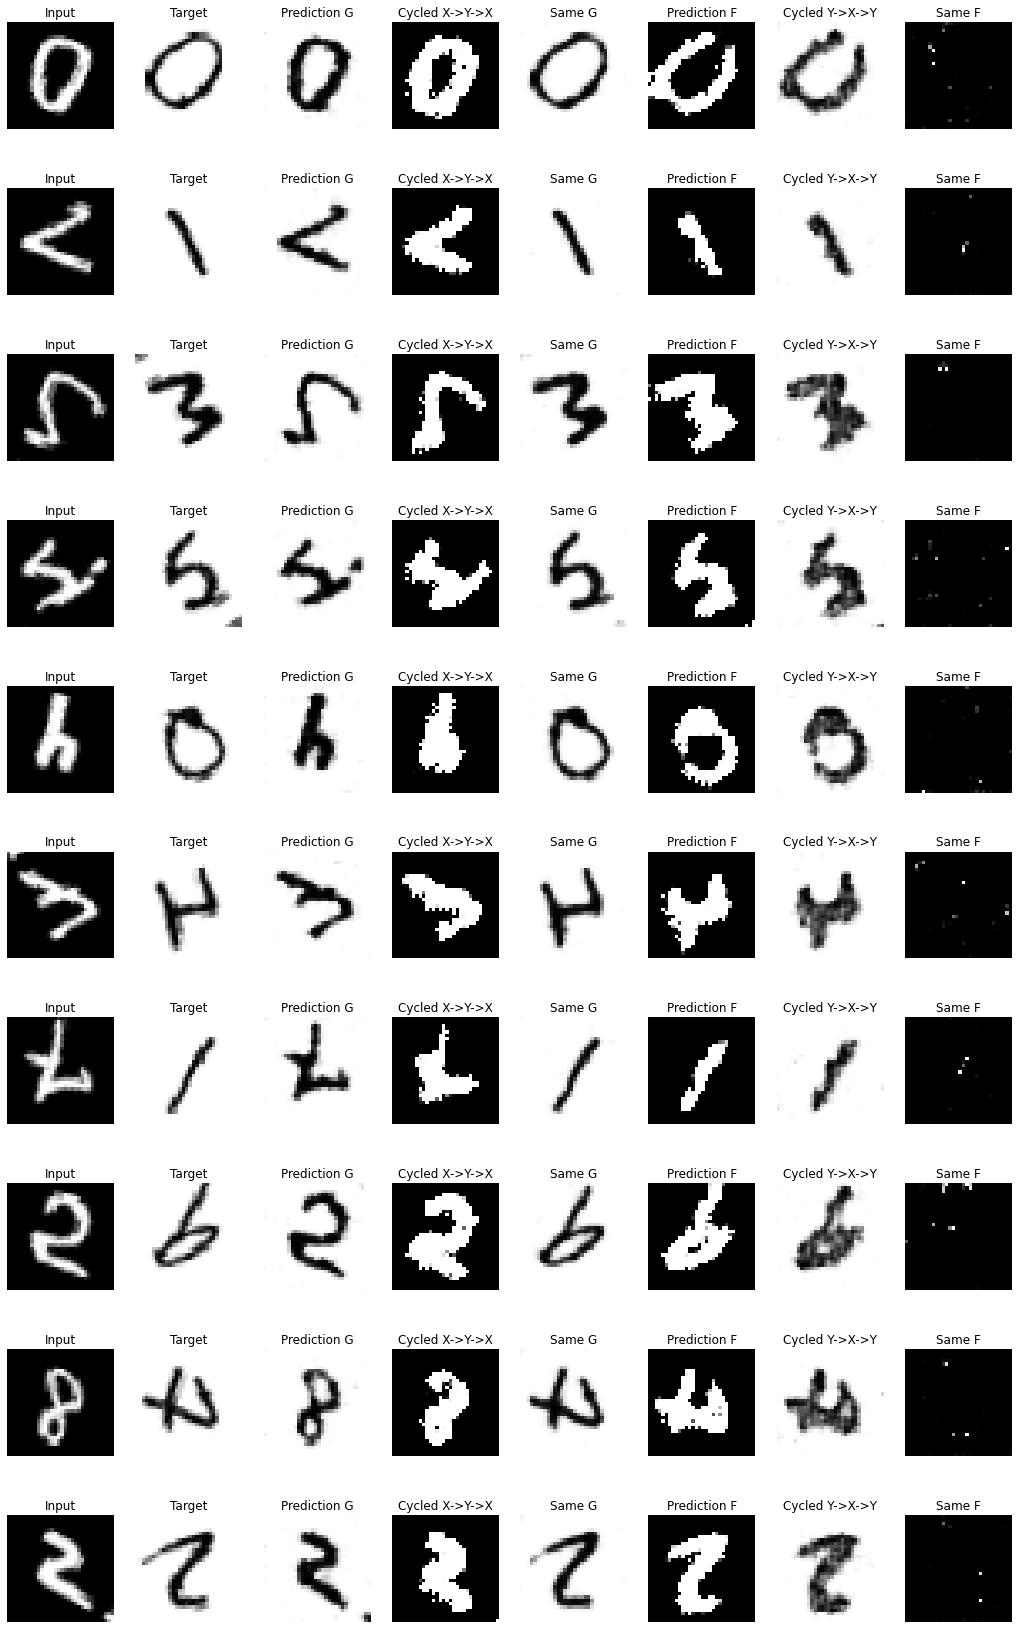

Step: 5000
.

In [17]:
cyclegan = CycleGAN(
    gen_g = generator_g,
    gen_f = generator_f,
    disc_x = discriminator_x,
    disc_y = discriminator_y,
    gen_g_optim = generator_g_optimizer,
    gen_f_optim = generator_f_optimizer,
    disc_x_optim = discriminator_x_optimizer,
    disc_y_optim = discriminator_y_optimizer,
    summary_writer = summary_writer,
    checkpoint = checkpoint,
    checkpoint_prefix = checkpoint_prefix,
    img_size=IMG_SIZE
)

train_history, val_history = cyclegan.fit(tf_train_contrast, tf_test_contrast, steps=5000, test_generation_period=500, n_test_examples=10)

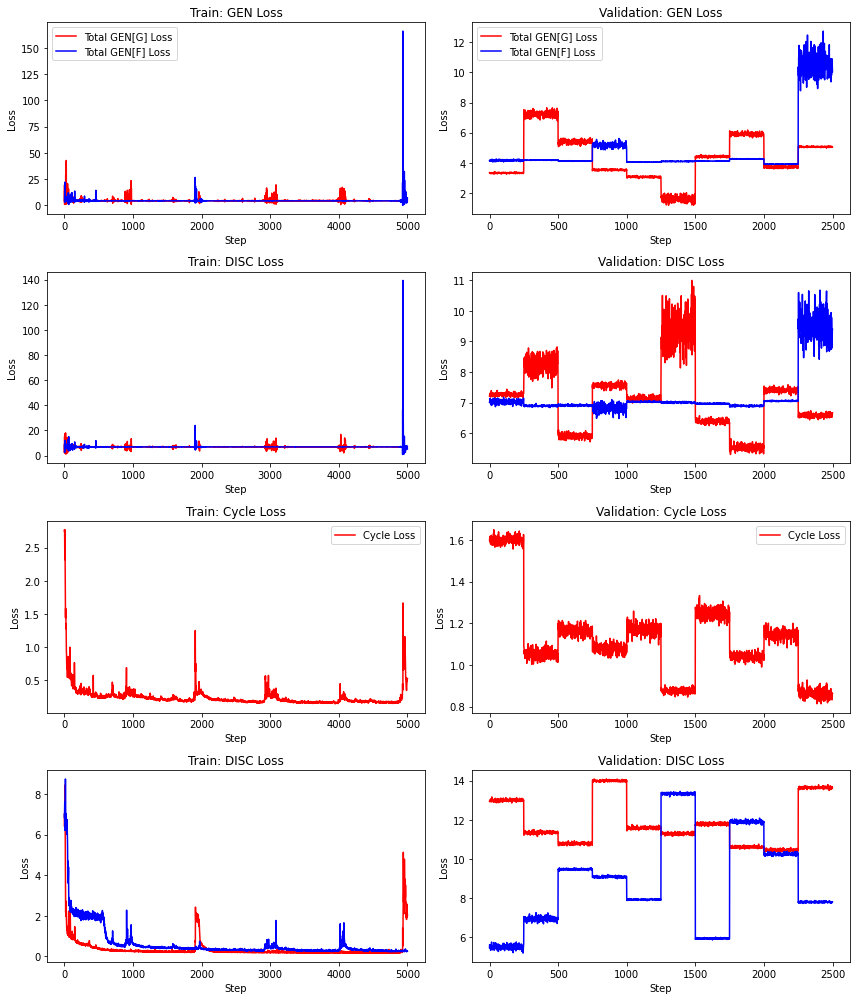

In [18]:
def plot_history(history, axs, col, prefix=''):
    """
    :param history: Istorija funkcije greske
    :param axs: Grafice nad kojim se slika
    :param col: Kolona koja se popunjava (ako ima vise skupova, moze da se gleda uporedo rezultat)
    :param prefix: Prefiks za rezultat u izabranoj koloni
    """
    gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, total_cycled_loss, identity_x_loss, identity_y_loss = \
        zip(*history)
    
    axs[0][col].plot(gen_g_loss, color='red', label='Total GEN[G] Loss')
    axs[0][col].plot(gen_f_loss, color='blue', label='Total GEN[F] Loss')
    axs[0][col].set_title(f'{prefix} GEN Loss')
    axs[0][col].set_xlabel('Step')
    axs[0][col].set_ylabel('Loss')
    axs[0][col].legend()

    axs[1][col].plot(disc_y_loss, color='red', label='Total DISC[Y] loss')
    axs[1][col].plot(disc_x_loss, color='blue', label='Total DISC[X] loss')
    axs[1][col].set_title(f'{prefix} DISC Loss')
    axs[1][col].set_xlabel('Step')
    axs[1][col].set_ylabel('Loss')

    axs[2][col].plot(total_cycled_loss, color='red', label='Cycle Loss')
    axs[2][col].set_title(f'{prefix} Cycle Loss')
    axs[2][col].set_xlabel('Step')
    axs[2][col].set_ylabel('Loss')
    
    axs[3][col].plot(identity_x_loss, color='red', label='Total Identity[X] loss')
    axs[3][col].plot(identity_y_loss, color='blue', label='Total Identity[Y] loss')
    axs[3][col].set_title(f'{prefix} DISC Loss')
    axs[3][col].set_xlabel('Step')
    axs[3][col].set_ylabel('Loss')
    
    axs[2][col].legend()


def plot_training_results(train_history, val_history):
    """
    Prikazuje grafike koji predstavljaju rezultate treniranja nad skupom za ucenje i nad skupom za validaciju.
    :param train_history: Istorija funkcije greske nad skupom za ucenje
    :param val_history: Istorija funkcije greske nad skupom za validaciju
    """
    fig, axs = plt.subplots(figsize=(12, 14), nrows=4, ncols=2)
    plot_history(train_history, axs, col=0, prefix='Train:')
    plot_history(val_history, axs, col=1, prefix='Validation:')
    plt.tight_layout()
    
plot_training_results(train_history, val_history)